# CHICAGO FOOD INSPECTIONS 📋

Esta información se deriva de inspecciones de restaurantes y otros establecimientos de comida en Chicago desde el 1 de enero de 2010 hasta el presente. Las inspecciones las realiza el personal del Programa de Protección de Alimentos del Departamento de Salud Pública de Chicago utilizando un procedimiento estandarizado. Los resultados de la inspección se ingresan en una base de datos, luego son revisados y aprobados por un pasante de salud ambiental con licencia del estado de Illinois (LEHP, por sus siglas en inglés).

Este `notebook` muestra de manerá rápida un Análisis exploratorio inicial de los datos.

A continuación procederemos a importar las librerías que utilizaremos.

## 0. Cargando librerias

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import geopandas as gpd
import contextily as ctx

from descartes import PolygonPatch
from geopandas import GeoDataFrame as gdf

## 1. Descarga y revisión de las variables
A continuación procederemos a cargar nuestros datos y hacer una inspección breve.

In [2]:
data = pd.read_csv('data/Food_Inspections.csv')
data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2473041,ROSATI'S GRANT PARK,ROSATI'S,2762683.0,Restaurant,Risk 1 (High),23 E ADAMS ST,CHICAGO,IL,60603.0,01/22/2021,License,Pass,NaN,41.879391,-87.626848,"(-87.62684825563626, 41.879391313239694)"
1,2456537,ACE BOUNCE,ACE BOUNCE,2431682.0,Restaurant,Risk 1 (High),230 N CLARK ST,CHICAGO,IL,60601.0,11/12/2020,Non-Inspection,No Entry,NaN,41.886552,-87.631142,"(-87.63114162542584, 41.88655161219518)"
2,2456374,THE PRODUCE CENTER,THE PRODUCE CENTER,44723.0,Grocery Store,Risk 1 (High),5820 N MILWAUKEE AVE,CHICAGO,IL,60646.0,11/06/2020,Canvass,Out of Business,NaN,41.987270,-87.778516,"(-87.77851570480085, 41.9872696368058)"
3,2456274,TRATTORIA ULTIMO,TRATTORIA ULTIMO,2069755.0,Restaurant,Risk 1 (High),1953 W CHICAGO AVE,CHICAGO,IL,60622.0,11/05/2020,Canvass,Out of Business,NaN,41.895808,-87.676752,"(-87.67675213462381, 41.89580774819584)"
4,2456264,MISS SAIGON,MISS SAIGON,2699550.0,Restaurant,Risk 1 (High),1129 W ARGYLE ST,CHICAGO,IL,60640.0,11/05/2020,Canvass Re-Inspection,Pass,NaN,41.973148,-87.658956,"(-87.65895612095852, 41.97314767068932)"


In [3]:
print(format(len(data),","))

216,490


In [4]:
data.isnull().sum()

Inspection ID          0
DBA Name               0
AKA Name            2487
License #             17
Facility Type       4891
Risk                  69
Address                0
City                 161
State                 50
Zip                   46
Inspection Date        0
Inspection Type        1
Results                0
Violations         57850
Latitude             716
Longitude            716
Location             716
dtype: int64

A continuación un diagrama para visualizar mejor esto.

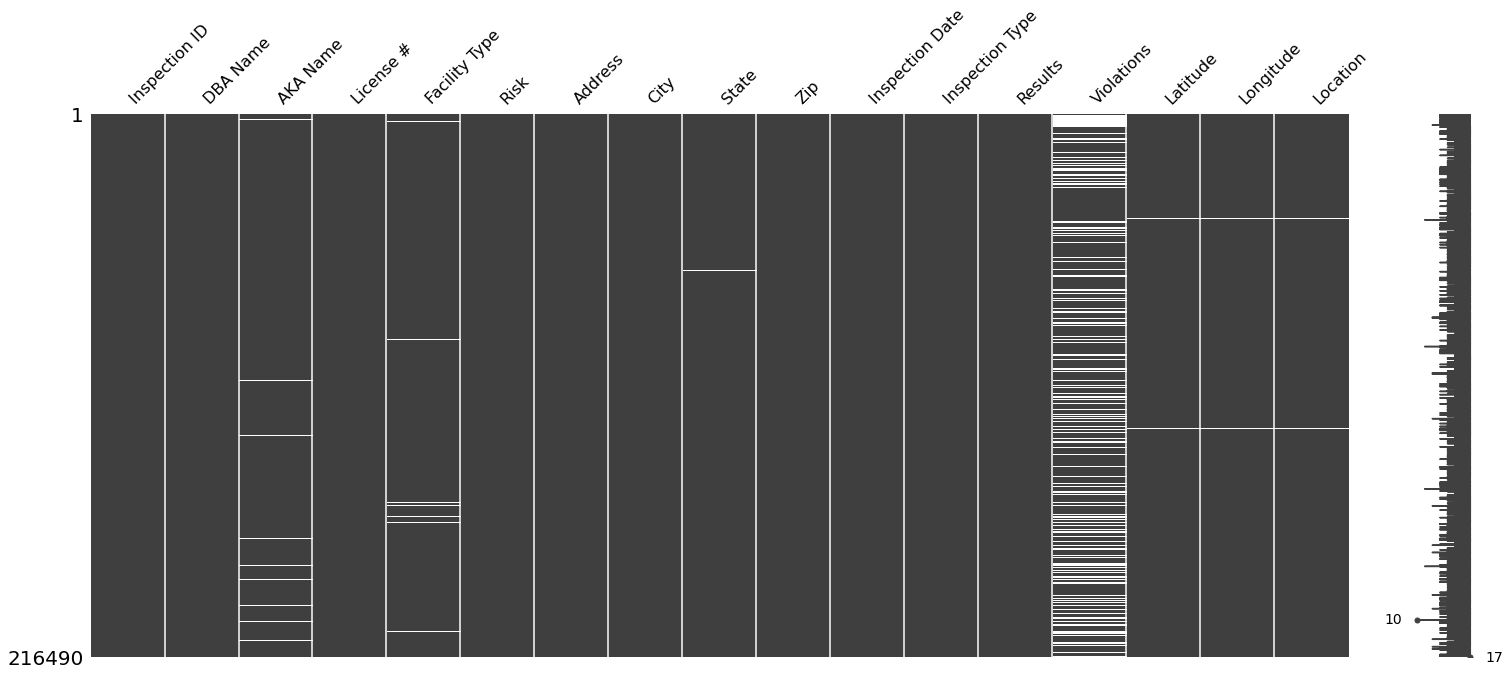

In [5]:
msno.matrix(data)

In [6]:
data = data.dropna(subset = ['Violations','Facility Type','Latitude','Longitude','AKA Name'])
data.isnull().sum()

Inspection ID       0
DBA Name            0
AKA Name            0
License #          11
Facility Type       0
Risk                1
Address             0
City               71
State              27
Zip                10
Inspection Date     0
Inspection Type     0
Results             0
Violations          0
Latitude            0
Longitude           0
Location            0
dtype: int64

In [7]:
print(format(len(data),","))

156,903


In [8]:
data.describe(exclude=[np.number])

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Results,Violations,Location
count,156903,156903,156903,156902,156903,156832,156876,156903,156903,156903,156903,156903
unique,22576,21862,423,3,16297,14,1,2776,57,6,155960,15600
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,09/29/2016,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,"(-87.91442843927047, 42.008536400868735)"
freq,2396,2955,107980,118592,2227,156464,156876,111,86732,86309,11,2233


## 2. Análisis multivariado.

Este análisis se enfoca primero a hacer una revisión por fechas y después a una inspección geo espacial.

Primero, separaremos las fechas en, día, mes y año.

In [9]:
data['month'] = data['Inspection Date'].apply(lambda x:x.split('/')[0])
data['day'] = data['Inspection Date'].apply(lambda x:x.split('/')[1])
data['year'] = data['Inspection Date'].apply(lambda x:x.split('/')[2].split('T')[0])

Text(0.5, 0, 'mes')

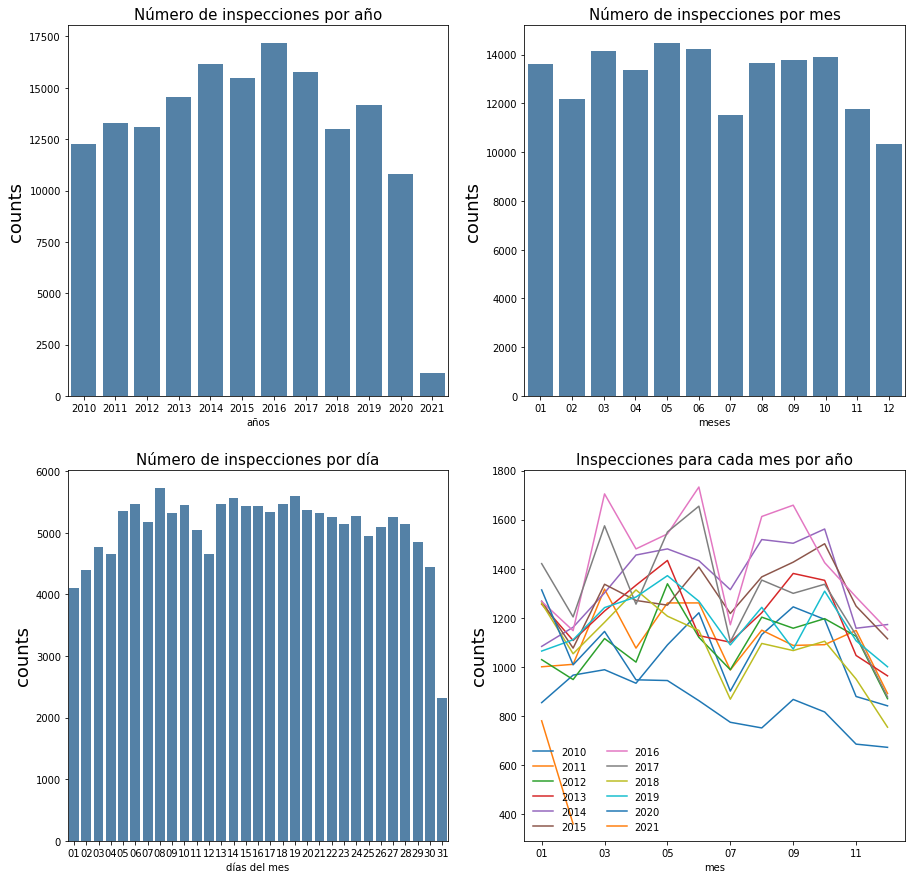

In [10]:
fig,ax=plt.subplots(2,2,figsize=(15,15))
label_colors = ["steelblue","steelblue","steelblue","steelblue",
                "steelblue","steelblue","steelblue","steelblue",
                "steelblue","steelblue","steelblue","steelblue"]
label_Palette = sns.set_palette(sns.color_palette(label_colors))
##sns.color_palette()
##sns.set_palette(sns.color_palette("Paired"))
x=data.year.value_counts().index
y=data.year.value_counts()

sns.barplot(x=x,y=y,ax=ax[0,0],order=x.sort_values())
ax[0,0].set_title("Número de inspecciones por año",size=15)
ax[0,0].set_ylabel('counts',size=18)
ax[0,0].set_xlabel('años')

x=data.month.value_counts().index
y=data.month.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,1],order=x.sort_values())
ax[0,1].set_title("Número de inspecciones por mes",size=15)
ax[0,1].set_ylabel('counts',size=18)
ax[0,1].set_xlabel('meses')

label_colors = ["steelblue","steelblue","steelblue","steelblue",
                "steelblue","steelblue","steelblue","steelblue",
                "steelblue","steelblue","steelblue","steelblue",
                "steelblue","steelblue","steelblue","steelblue",
                "steelblue","steelblue","steelblue","steelblue",
                "steelblue","steelblue","steelblue","steelblue",
                "steelblue","steelblue","steelblue","steelblue",
                "steelblue","steelblue","steelblue"]
label_Palette = sns.set_palette(sns.color_palette(label_colors))
x=data.day.value_counts().index
y=data.day.value_counts()
sns.barplot(x=x,y=y,ax=ax[1,0],order=x.sort_values())
ax[1,0].set_title("Número de inspecciones por día",size=15)
ax[1,0].set_ylabel('counts',size=18)
ax[1,0].set_xlabel('días del mes')

sns.set_palette(sns.set_palette("pastel"))
data.groupby(['year','month'])['Inspection ID'].agg('count').unstack('year').plot(ax=ax[1,1])
ax[1,1].set_title("Inspecciones para cada mes por año",size=15)
ax[1,1].legend(loc='lower left', frameon=False, ncol=2)
ax[1,1].set_ylabel('counts',size=18)
ax[1,1].set_xlabel('mes')

La gráfica de la izquierda superior nos muestra que las inspecciones se concentraron entre 2014 y 2018, siendo 2016 el año en que se reporta el mayor número. Es claro el impacto de la pandemia en la frecuencia de las inspecciones, puesto que durante 2020 se reporta un descenso notable de éstas.

La gráfica superior derecha nos muestra las inspecciones por mes. No se observa una tendencia clara, sin embargo podemos observar que en los meses de mayo y junio se concentra el mayor número de inspecciones y durante diciembre este número disminuye.

La gráfica inferior izquierda muestra el número de inspecciones por día del mes. La tendencia no es clara, sin embargo destaca que el día 31 existen menos registros, lo que puede deberse a que no todos los meses tienen este día.

La gráfica de la derecha inferior muestra la relación entre año y mes de los registros. Es notorio que los picos son consistentes entre años, apesar de encontrarse en distintos niveles según el año. Durante 2020 tenemos el menor número de registros mismo que como ya mencionamos puede deberse a un menor número de inspecciones a consecuencia de la contingencia sanitaria.


También podemos observar estos mismos resultados mediante gráficos como "heat maps"  de una forma más clara.

In [11]:
year = data[["year"]]
year = year.astype(int)

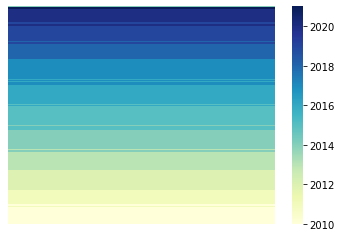

In [40]:
heat_map = sns.heatmap(year,xticklabels=False, yticklabels=False,cmap="YlGnBu")
plt.show()

En este caso observamos que el mayor número de inspecciones se realizó durante los primeros años y la frecuiencia disminuyó a lo largo del tiempo.

In [13]:
month = data[["month"]]
month = month.astype(int)

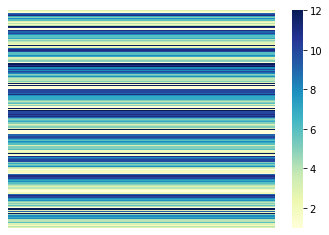

In [42]:
heat_map_2 = sns.heatmap(month,xticklabels=False, yticklabels=False,cmap="YlGnBu")
plt.show()

Aquí podemos apreciar que se reportó el mayor número de visitas a los establecimientos durante los primeros seis meses de cada año.


In [15]:
day = data[["day"]]
day = day.astype(int)

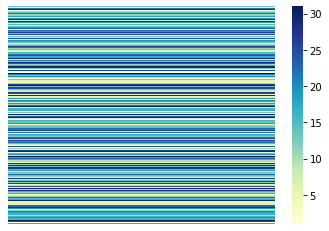

In [43]:
heat_map_3 = sns.heatmap(day,xticklabels=False, yticklabels=False, cmap="YlGnBu")
plt.show()

Se puede observar de forma más clara que el mayor número de inpecciones a establecimientos de comida se realizó durantre los primeros 10 días de cada mes.

## 3. Análisis Geográfico
Descargamos los datos con información de los polígonos con límites geográficos de Chicago.

Fuente: https://www.lib.uchicago.edu/e/collections/maps/uofcgis.html

In [17]:
ward1998 = gpd.read_file("data/ward1998.shp")


Eliminamos las filas que no contengan información numérica de la columna "Latitude"

In [18]:
data = data[pd.to_numeric(data['Latitude'], errors='coerce').notnull()]

Preparamos la base para la ubicación de los puntos donde se realizaron inspecciones con información de las columnas "Latitude" e "Longitude".

In [19]:
points= gdf(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))

Presentamos la visualización de la base, una vez acondicionada para ubicar los puntos. La información se encuentra contenida en la columna "geometry".

In [20]:
points[:3]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Inspection Type,Results,Violations,Latitude,Longitude,Location,month,day,year,geometry
6,2453719,LAS ISLAS MARIAS,LAS ISLAS MARIAS,1095992.0,Restaurant,Risk 1 (High),4770 W GRAND AVE,CHICAGO,IL,60639.0,...,Complaint,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.913999,-87.745864,"(-87.74586369218258, 41.91399920930635)",10,22,2020,POINT (-87.74586 41.91400)
12,2387078,DINNER AND A MOVIE,DINNER AND A MOVIE,2749481.0,Restaurant,Risk 1 (High),2500 N ASHLAND AVE,CHICAGO,IL,60614.0,...,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.927051,-87.668359,"(-87.66835947589291, 41.92705136177427)",09,11,2020,POINT (-87.66836 41.92705)
34,2369400,DSD DELI,DSD DELI,2626178.0,DELI/GROCERY,Risk 1 (High),5205 N MILWAUKEE,CHICAGO,IL,60630.0,...,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.974849,-87.766829,"(-87.76682905043768, 41.97484853157327)",04,17,2020,POINT (-87.76683 41.97485)


Visualización de los datos que contiene información sobre los polígonos de Chicago

In [21]:
ward1998[:3]

,WARD,COUNT,geometry
0,10,46,"POLYGON ((-87.52494 41.70264, -87.52502 41.701..."
1,11,54,"POLYGON ((-87.65534 41.80873, -87.65535 41.808..."
2,12,30,"POLYGON ((-87.67976 41.83914, -87.67795 41.835..."


Se transforman los datos a crs paratener una base para el mapa

In [22]:
ward1998 = ward1998.to_crs(epsg=3857)

In [23]:
points.crs = "EPSG:4326"
points = points.to_crs(epsg=3857)

Ahora, visualicemos nuestro mapa

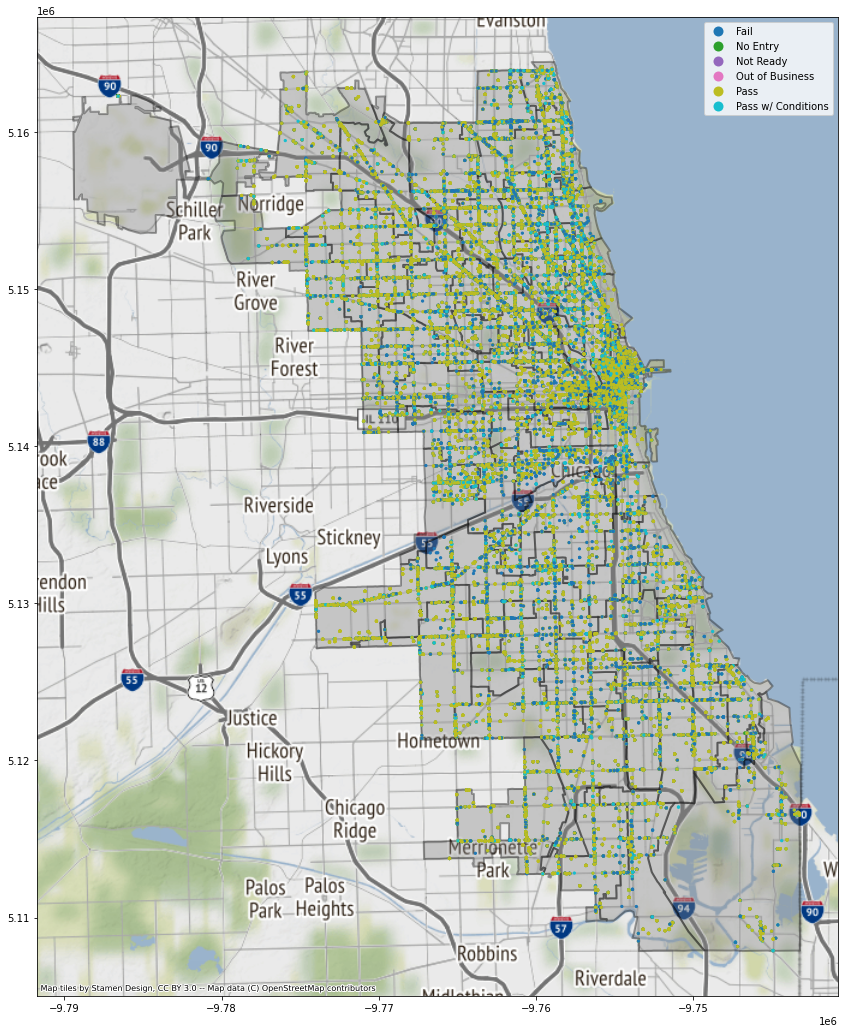

In [24]:
ax = ward1998.plot(figsize=(18, 18), alpha=0.35, edgecolor='black',color='gray', linewidth=2)
points.plot(ax=ax, markersize=5, marker="o", column='Results',legend=True)
ctx.add_basemap(ax)

El mapa muestra una concentración de inspecciones en la zona centro de Chicago. Los resultados más comunes son inspecciones aprobadas "Pass", seguidas de reprobadas "Fail". En tercer lugar, aparecen las inspecciones aprobadas con condiciones "Pass w/Conditions". Asimismo, podemos recalcar que el número de inspecciones aprobadas es casi tres veces el número de inspecciones reprobadas. Otro aspecto que llama la atención es el trazo casi perfecto de calles y avenidas donde se ubican los establecimientos.

In [25]:
count = data['Results'].value_counts() 
print(format(count),",")

Pass                  86309
Fail                  37940
Pass w/ Conditions    32013
No Entry                548
Not Ready                63
Out of Business          30
Name: Results, dtype: int64 ,
